# Hierarchical Time Series


### Referências: 
- https://otexts.com/fpp3/hts.html
- https://www.occasionaldivergences.com/post/stan-hierarchical/
- https://mc-stan.org/docs/2_24/stan-users-guide/autoregressive-section.html


### Esboço do projeto
- Seção "Problema" está mais atualizada.
- Os modelos desse notebook ainda não seguem essas ideias, são modelos gerados para dados agregados.

1. Problema:
    - Série-temporal, auto regressão: IDEB[N] ~ alpha + beta*IDEB[N-1]
    - Ainda estou incerta quanto a como modelar o problema.
        - Uma regressão geral para todas as cidades.
            - Era como estava tentando desenvolver no "Desenvolvimento", mas parou de fazer tanto sentido.
        - Cada cidade tem sua regressão, porém com compartilhamento de parâmetros.
            - Qual hierarquia (estado, região) é mais eficiente para predição do IDEB 2019 de cada cidade?
            - Cada cidade tem sua regressão.
            - N = anos.
            - Fully pooled: $IDEB[cidade][N] ~ alpha + beta*IDEB[cidade][N-1]$
            - Hierarquia por região (5): $IDEB[cidade][N] ~ alpha[regiao[cidade]] + beta[regiao[cidade]]*IDEB[cidade][N-1]$
            - Hierarquia por estado (27): $IDEB[cidade][N] ~ alpha[estado[cidade]] + beta[estado[cidade]]*IDEB[cidade][N-1]$
        
    
2. Desenvolvimento:

    2.1 Baseline: Fully pooled.
        - Agregar todos os dados do Brasil anualmente.
        - Um único Beta.
        
    2.2 Hierarquização:
    
        - Por Região.
            - Cada região tem seu próprio beta (5 betas).
            - IDEB[N] ~ alpha + beta[region[N]]*IDEB[N-1]
            - beta[R] ~ normal(0, 10)
            
        - Por Estado.
            - Cada estado tem seu próprio beta (27 betas com o DF).
            - IDEB[N] ~ alpha + beta[estado[N]]*IDEB[N-1]
            - beta[E] ~ normal(0, 10)
            
        - Um parâmetro para estado e outro para região.
            - IDEB[N] ~ alpha + tau*beta*IDEB[N-1]
            - beta[E] ~ normal(0, 10)
            - tau[R] ~ normal(0, 10)
            
        - Trazendo informação de capital ou interior (heterarquia).
        
3. Dúvidas

    - Tem como colocar todos os dados (sem agregação) no stan? Temos múltiplos valores para cada Ano.
    - Como adicionamos mais um elemento (tipo ter um beta para estado, um tau para região e um zeta para capital).

In [21]:
import pandas as pd
import pystan
import numpy as np
import plotly.express as px

import seaborn as sns
from matplotlib import pyplot as plt
from graphviz import Digraph

sns.set_theme()

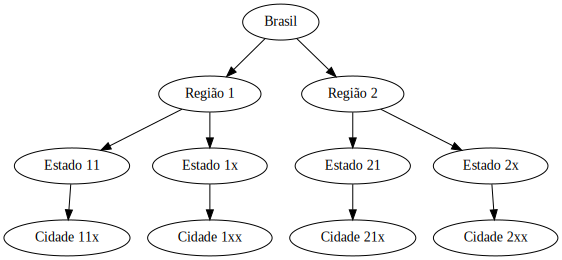

In [108]:
# TODO add no requirements
# !sudo apt install graphviz
# !pip install graphviz

g = Digraph()
g.attr(compound='true')
g.edge("Brasil", "Região 1")
g.edge("Brasil", "Região 2")
g.edge("Região 1", "Estado 11")
g.edge("Região 1", "Estado 1x")
g.edge("Região 2", "Estado 21")
g.edge("Região 2", "Estado 2x")
g.edge("Estado 11", "Cidade 11x")
g.edge("Estado 1x", "Cidade 1xx")
g.edge("Estado 21", "Cidade 21x")
g.edge("Estado 2x", "Cidade 2xx")

g

In [22]:
df_raw = pd.read_csv("../outputs/ideb_merged_middle.csv", index_col=0)

In [23]:
df_raw

,Código do Município,Sigla da UF,Regiões,Nome do Município,Rede,Ano,IDEB
0,1100015,RO,Norte,Alta Floresta D'Oeste,Pública,2005,3.5
1,1100023,RO,Norte,Ariquemes,Pública,2005,3.5
2,1100031,RO,Norte,Cabixi,Pública,2005,3.8
3,1100049,RO,Norte,Cacoal,Pública,2005,3.6
4,1100056,RO,Norte,Cerejeiras,Pública,2005,3.6
...,...,...,...,...,...,...,...
114979,4314902,RS,Sul,Porto Alegre,Federal,2019,6.9
114980,4316907,RS,Sul,Santa Maria,Federal,2019,7.4
114981,5002704,MS,Centro-Oeste,Campo Grande,Federal,2019,7.2
114982,5208707,GO,Centro-Oeste,Goiânia,Federal,2019,NaN


In [24]:
categories = ["Sigla da UF", "Regiões", "Nome do Município", "Rede"]

df = df_raw.dropna()
df[categories] = df[categories].astype('category')

df = df.query("Rede == 'Pública'")

/home/luiza/anaconda3/envs/ia368/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [25]:
df_train = df.query("Ano != 2019")
df_test = df.query("Ano == 2019")

In [62]:
main_col = "Sigla da UF"
group_cols = ["Sigla da UF", "Regiões", "Ano"]
grouped_data = pd.pivot_table(df_train, index=group_cols, values=["IDEB"]).reset_index()
grouped_brasil = pd.pivot_table(df_train, index="Ano", values="IDEB").reset_index()
grouped_brasil["Sigla da UF"] = "Brasil"
grouped_brasil["Regiões"] = "Brasil"

grouped = pd.concat([grouped_data, grouped_brasil])

In [63]:
px.line(grouped, x="Ano", y="IDEB", color="Regiões")

In [102]:
def stratified_sample(df, regions, years, cities_by_region=10):
    cities = [df.query("Regiões == @r")
              .sample(cities_by_region)["Nome do Município"]
              .values 
              for r in regions]
    cities = [c for cs in cities for c in cs]

    return df[df["Nome do Município"].isin(cities)]

In [103]:
regions = df["Regiões"].unique()
years = df["Ano"].unique()
sample = stratified_sample(df, regions, years, cities_by_region=10)

In [104]:
sample

,Código do Município,Sigla da UF,Regiões,Nome do Município,Rede,Ano,IDEB
22,1100320,RO,Norte,São Miguel do Guaporé,Pública,2005,3.7
40,1101435,RO,Norte,Nova União,Pública,2005,2.8
63,1200351,AC,Norte,Marechal Thaumaturgo,Pública,2005,2.5
91,1301100,AM,Norte,Careiro,Pública,2005,2.9
204,1503309,PA,Norte,Igarapé-Miri,Pública,2005,3.0
...,...,...,...,...,...,...,...
44307,5200605,GO,Centro-Oeste,Alto Paraíso de Goiás,Pública,2019,4.0
44364,5205703,GO,Centro-Oeste,Córrego do Ouro,Pública,2019,5.6
44371,5206602,GO,Centro-Oeste,Cumari,Pública,2019,5.6
44460,5214903,GO,Centro-Oeste,Nova Roma,Pública,2019,4.8


# Modelos

TODO 

- [ ]: generated quantities -> predição de 2019 das cidades

## Fully pooled

In [141]:
fully_pooled = """
data {
  int<lower=0> N;         // number of years
  real y[N];              // estimated IDEB score
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  for (n in 2:N)
    y[n] ~ normal(alpha + beta * y[n-1], sigma);
}
generated quantities {
  real y_pred;
  real y_rep[N];
  
  y_pred = normal_rng(alpha + beta * y[N], sigma);
  
  y_rep[1] = y[1];
  for (n in 2:N)
    y_rep[n] = normal_rng(alpha + beta * y_rep[n-1], sigma);
}
"""

In [147]:
sample = df_train.groupby("Ano").mean()
sample

,Código do Município,IDEB
Ano,,
2005,3.240032e+06,3.310714
2007,3.249659e+06,3.538081
2009,3.245708e+06,3.790495
2011,3.253780e+06,3.927665
2013,3.247747e+06,4.041059
2015,3.220040e+06,4.213617
2017,3.247057e+06,4.379550


In [125]:
data = {
    "N": sample.shape[0],
    "y": sample["IDEB"].values,
}

In [142]:
fit = pystan.stan(model_code=fully_pooled, 
                  data=data, 
                  control={"adapt_delta": 0.99},
                  chains=4, 
                  iter=1000, 
                  seed=42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dc1861806b8dfce351b5482040986aea NOW.


In [143]:
fit

Inference for Stan model: anon_model_dc1861806b8dfce351b5482040986aea.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

           mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha      0.59    0.02    0.42  -0.23   0.36   0.59   0.78   1.44    309   1.01
beta       0.89  6.2e-3    0.11   0.67   0.84   0.89   0.95   1.11    307   1.01
sigma      0.07  3.2e-3    0.05   0.03   0.04   0.06   0.08   0.21    248   1.02
y_pred      4.5  4.7e-3    0.12   4.27   4.45    4.5   4.55   4.74    639    1.0
y_rep[1]   3.31 6.3e-16 8.9e-16   3.31   3.31   3.31   3.31   3.31      2    1.0
y_rep[2]   3.55  4.1e-3    0.11   3.36   3.49   3.54   3.59   3.78    704   1.01
y_rep[3]   3.75  5.3e-3    0.16   3.43   3.68   3.75   3.82   4.04    876    1.0
y_rep[4]   3.93  5.8e-3     0.2   3.57   3.85   3.93   4.01   4.29   1150    1.0
y_rep[5]   4.08  5.6e-3    0.23   3.63    4.0   4.09   4.18   4.48   1628    1.0
y_r

In [145]:
fit["y_pred"].mean(), df_test.groupby("Ano").mean().loc[2019]["IDEB"]

(4.498716050983715, 4.613221108379019)

## Hierarquização

### Por região

In [169]:
sample = pd.pivot_table(df_train, index=["Regiões", "Ano"], values="IDEB").reset_index()
sample["Regiões"] = sample["Regiões"].cat.codes + 1
sample

,Regiões,Ano,IDEB
0,1,2005,3.301860
1,1,2007,3.641991
2,1,2009,3.875000
3,1,2011,4.053215
4,1,2013,4.391028
5,1,2015,4.608909
6,1,2017,4.932680
7,2,2005,2.667780
8,2,2007,2.882185
9,2,2009,3.110323


In [170]:
data = {
    "N": sample.shape[0],
    "y": sample["IDEB"].values,
    "R": len(sample["Regiões"].unique()),
    "region": sample["Regiões"],
}

In [171]:
region_agg = """
data {
  int<lower=0> N;         // number of years
  int<lower=0> R;         // number of regions
  real y[N];              // estimated IDEB score
  int<lower=1, upper=R> region[N]; // region of each sample
}
parameters {
  real alpha;
  vector[R] beta;
  real<lower=0> sigma;
}
model {
  
  // todo: not sure this is the correct way to do hierarchies
  
  // sample region beta
  for (r in 1:R) {
    beta[r] ~ normal(0, 10);
  }

  for (n in 2:N)
    y[n] ~ normal(alpha + beta[region[n]] * y[n-1], sigma);
}
generated quantities {
  real y_pred[R];
  real y_rep[N];
  
  // todo: verify if this is the correct way to predict
  for (r in 1:R)
    y_pred[r] = normal_rng(alpha + beta[r] * y[N], sigma);
  
  y_rep[1] = y[1];
  for (n in 2:N)
    y_rep[n] = normal_rng(alpha + beta[region[n]] * y_rep[n-1], sigma);
}
"""

In [172]:
fit = pystan.stan(model_code=region_agg, 
                  data=data, 
                  control={"adapt_delta": 0.99},
                  chains=4, 
                  iter=1000, 
                  seed=42)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af15e4350d6068de68bcb5d021f1da7d NOW.


In [173]:
fit

Inference for Stan model: anon_model_af15e4350d6068de68bcb5d021f1da7d.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        2.8    0.03    0.53   1.73   2.46    2.8   3.19   3.73    233   1.01
beta[1]     0.37  8.7e-3    0.14   0.13   0.27   0.37   0.46   0.65    244   1.01
beta[2]     0.12    0.01    0.15  -0.16 5.4e-3   0.11   0.22   0.44    221   1.01
beta[3]     0.22 10.0e-3    0.15  -0.06    0.1   0.22   0.32   0.53    235   1.02
beta[4]     0.37  8.2e-3    0.13   0.14   0.28   0.37   0.45   0.62    236   1.01
beta[5]     0.34  8.2e-3    0.13   0.11   0.25   0.34   0.42   0.59    240   1.01
sigma       0.35  2.1e-3    0.05   0.27   0.31   0.34   0.38   0.45    545   1.01
y_pred[1]   4.56    0.01    0.41   3.75    4.3   4.55   4.83   5.38   1660    1.0
y_pred[2]   3.36    0.01    0.44   2.49   3.08   3.37   3.65    4.2    873 

In [174]:
params = fit.extract()

In [175]:
params["y_pred"].mean(axis=0), pd.pivot_table(df_test, index=["Regiões", "Ano"], values="IDEB").reset_index()

(array([4.5607822 , 3.36249667, 3.84344059, 4.55664212, 4.40909039]),
         Regiões   Ano      IDEB
 0  Centro-Oeste  2019  4.900920
 1      Nordeste  2019  4.172155
 2         Norte  2019  4.116019
 3       Sudeste  2019  4.911659
 4           Sul  2019  4.943566)

LinAlgError: singular matrix

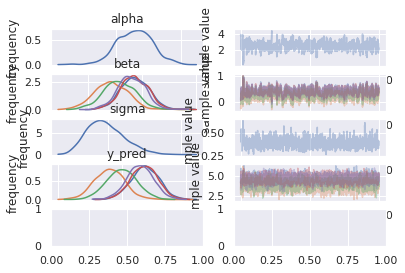

In [162]:
fit.traceplot()
plt.show()

In [163]:
params = fit.to_dataframe()
params

,chain,draw,warmup,alpha,beta[1],beta[2],beta[3],beta[4],beta[5],sigma,...,y_rep[38],y_rep[39],y_rep[40],lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__
0,0,0,0,3.825518,0.170612,-0.210098,-0.042706,0.079779,0.123625,0.465961,...,4.383321,4.964937,5.665734,13.357115,0.987378,0.039977,6,127,0,-11.055972
1,0,1,0,3.975380,0.179540,-0.240031,-0.039052,0.087181,0.130129,0.470979,...,4.334732,4.898595,4.756943,11.688438,0.975681,0.039977,4,15,0,-9.383109
2,0,2,0,3.799637,0.056468,-0.067226,-0.079070,0.162938,0.077271,0.503580,...,3.602311,3.439481,3.554355,11.764031,0.999034,0.039977,5,31,0,-7.862506
3,0,3,0,3.848071,0.192977,-0.239118,-0.059720,0.127816,0.115516,0.462205,...,2.923510,4.099198,3.744198,13.109655,0.999401,0.039977,5,31,0,-10.244100
4,0,4,0,2.800935,0.341293,0.106830,0.222374,0.372743,0.351623,0.403288,...,4.566095,4.937500,4.776864,18.846531,0.976996,0.039977,6,79,0,-6.972168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,3,495,0,2.147605,0.481156,0.396582,0.423783,0.484750,0.541095,0.365759,...,4.901101,4.901738,5.107780,15.627083,0.989532,0.046290,4,15,0,-11.406635
1996,3,496,0,2.104145,0.545745,0.413499,0.404902,0.440207,0.550926,0.388230,...,4.943033,4.490044,5.049836,13.104078,0.988067,0.046290,5,63,0,-8.545407
1997,3,497,0,2.134710,0.548934,0.416189,0.404921,0.427443,0.527822,0.392844,...,4.934646,5.419948,5.097882,12.673835,0.999754,0.046290,5,47,0,-10.834034
1998,3,498,0,2.277668,0.489835,0.280360,0.356581,0.530271,0.473803,0.409888,...,4.303420,4.539665,4.807089,19.196567,0.993289,0.046290,4,15,0,-9.822959


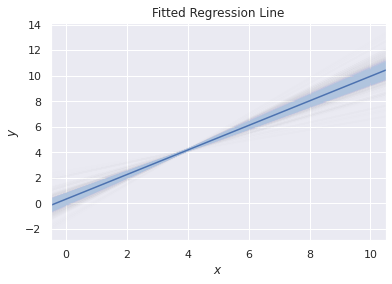

In [25]:
# Ref: https://towardsdatascience.com/an-introduction-to-bayesian-inference-in-pystan-c27078e58d53
# TODO: fazer um plot similar para nossos modelos.

# Extracting traces
alpha = params['alpha']
beta = params['beta']
sigma = params['sigma']
lp = params['lp__']

x = sample.index
y = sample["IDEB"].values
alpha_mean = np.mean(alpha)
beta_mean = np.mean(beta)

# Plotting regression line
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
for i in np.random.randint(0, len(alpha), 1000):
    plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue', 
             alpha=0.01)
# Plot mean regression line
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)
plt.show()